In [9]:
import pandas as pd
import numpy as np
import pickle
import os

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from matplotlib import pyplot as plt
import matplotlib
import tkinter
# matplotlib.use('TkAgg')
# do the inline thing
%matplotlib inline

import ugtm
from ugtm import eGTM
import altair as alt

from outlier import iqr_method, reorder_cols
from lcfunctions import download_lasair_lc, display_lightcurve
from lcfunctions import lasair_clean, load_lasair_lc

### Put together dataframe to generate dataset.

In [2]:
cvlistdate = '21032023'
lightcurvesdate = '08102023'
label_scheme = 'labels_1'
gaia = False

pd.options.display.max_columns = None

dataset = pd.read_csv(f'../processed_data/dataset_{cvlistdate}allfeatures_inc_labels{lightcurvesdate}.csv', low_memory=False)
dataset = dataset[dataset[label_scheme].notna()].reset_index(drop=True)
# Set negative values of distance to NaN
dataset['distance'] = dataset['distance'].apply(lambda x: np.nan if x<0 else x)
# drop rows with no Gaia data
# dataset = dataset[dataset['ra_error'].notna()].reset_index(drop=True)
# dataset = dataset[dataset['absmag_g'].notna()].reset_index(drop=True)

# Drop Gaia features
if gaia == False:
    dataset = dataset.iloc[:,:-34]

# Filter dataset
dataset_pts_threshold = dataset[(dataset['n_obs_g']>=20) | (dataset['n_obs_r']>=20)].reset_index(drop=True)
# dataset_timespan_threshold = dataset[dataset['temporal_baseline_g']>=365].reset_index(drop=True)

# Dataset going forward
dataset_final = dataset_pts_threshold

print(dataset_final[label_scheme].value_counts())

X = dataset_final.iloc[:,14:]
X_cols = X.columns.tolist()
y_names = dataset_final[label_scheme]
enc = LabelEncoder()
y = enc.fit_transform(y_names)
print(X.shape, y.shape, len(X_cols))

# Handle outliers
cap_cols1 = ['Period_fit_g','Period_fit_r']
cap_cols2 = ['pwr_max_g','pwr_max_r']
cap_cols3 = ['distance']

iqr_cols1 = ['LinearTrend_g','LinearTrend_r']
iqr_cols2 = ['clr_mean','clr_median', 'clr_bright','clr_faint']
iqr_cols3 = ['astrometric_sigma5d_max']
iqr_cols4 = ['bp_rp','bp_g','g_rp']
iqr_cols5 = ['absmag_g','absmag_bp','absmag_rp']

log_cols = ['Autocor_length_g','CAR_mean_g','CAR_sigma_g','Eta_e_g',
            'Freq1_harmonics_amplitude_0_g','Freq1_harmonics_amplitude_1_g',
            'Freq1_harmonics_amplitude_2_g','Freq1_harmonics_amplitude_3_g',
            'Freq2_harmonics_amplitude_0_g','Freq2_harmonics_amplitude_1_g',
            'Freq2_harmonics_amplitude_2_g','Freq2_harmonics_amplitude_3_g',
            'Freq3_harmonics_amplitude_0_g','Freq3_harmonics_amplitude_1_g',
            'Freq3_harmonics_amplitude_2_g','Freq3_harmonics_amplitude_3_g',
            'MaxSlope_g','PeriodLS_g','SlottedA_length_g',
            'Autocor_length_r','CAR_mean_r','CAR_sigma_r','Eta_e_r',
            'Freq1_harmonics_amplitude_0_r','Freq1_harmonics_amplitude_1_r',
            'Freq1_harmonics_amplitude_2_r','Freq1_harmonics_amplitude_3_r',
            'Freq2_harmonics_amplitude_0_r','Freq2_harmonics_amplitude_1_r',
            'Freq2_harmonics_amplitude_2_r','Freq2_harmonics_amplitude_3_r',
            'Freq3_harmonics_amplitude_0_r','Freq3_harmonics_amplitude_1_r',
            'Freq3_harmonics_amplitude_2_r','Freq3_harmonics_amplitude_3_r',
            'MaxSlope_r','PeriodLS_r','SlottedA_length_r'
            ]

log_cols2 = ['freq_pwr_max_g','pwr_maxovermean_g',
             'npeaks_pt5to1_g','rrate_pt5to1_g','drate_pt5to1_g', 
             'npeaks_1to2_g','rrate_1to2_g','drate_1to2_g',
             'npeaks_2to5_g','rrate_2to5_g','drate_2to5_g',
             'npeaks_above5_g','rrate_above5_g','drate_above5_g',
             'rollstd_ratio_t20s10_g','rollstd_ratio_t10s5_g',
             'pnts_leq_rollMedWin20-1mag_g','pnts_leq_rollMedWin20-2mag_g','pnts_leq_rollMedWin20-5mag_g',
             'pnts_geq_rollMedWin20+1mag_g','pnts_geq_rollMedWin20+2mag_g','pnts_geq_rollMedWin20+3mag_g',
             'pnts_leq_median-1mag_g','pnts_leq_median-2mag_g','pnts_leq_median-5mag_g',
             'pnts_geq_median+1mag_g','pnts_geq_median+2mag_g','pnts_geq_median+3mag_g',
             'freq_pwr_max_r','pwr_maxovermean_r',
             'npeaks_pt5to1_r','rrate_pt5to1_r','drate_pt5to1_r',
             'npeaks_1to2_r','rrate_1to2_r','drate_1to2_r',
             'npeaks_2to5_r','rrate_2to5_r','drate_2to5_r',
             'npeaks_above5_r','rrate_above5_r','drate_above5_r',
             'rollstd_ratio_t20s10_r','rollstd_ratio_t10s5_r',
             'pnts_leq_rollMedWin20-1mag_r','pnts_leq_rollMedWin20-2mag_r','pnts_leq_rollMedWin20-5mag_r',
             'pnts_geq_rollMedWin20+1mag_r','pnts_geq_rollMedWin20+2mag_r','pnts_geq_rollMedWin20+3mag_r',
             'pnts_leq_median-1mag_r','pnts_leq_median-2mag_r','pnts_leq_median-5mag_r',
             'pnts_geq_median+1mag_r','pnts_geq_median+2mag_r','pnts_geq_median+3mag_r'
             ]

log_cols3 = ['ra_error','dec_error',
            'parallax_error',
            'pm',
            'pmra_error',
            'pmdec_error',
            'phot_g_mean_flux',
            'phot_g_mean_flux_error',
            'phot_bp_mean_flux',
            'phot_bp_mean_flux_error',
            'phot_rp_mean_flux',
            'phot_rp_mean_flux_error',
            'distance'
            ]


log_transformer1 = FunctionTransformer(np.log1p, validate=False)
log_transformer2 = FunctionTransformer(np.log1p, validate=False)
log_transformer3 = FunctionTransformer(np.log1p, validate=False)

cap_transformer1 = FunctionTransformer(np.clip, validate=False, kw_args={'a_min':0, 'a_max':1})
cap_transformer2 = FunctionTransformer(np.clip, validate=False, kw_args={'a_min':0, 'a_max':1})
cap_transformer3 = FunctionTransformer(np.clip, validate=False, kw_args={'a_min':0, 'a_max':np.inf})

iqr_transformer1 = FunctionTransformer(iqr_method, validate=False, kw_args={'factor': 5})
iqr_transformer2 = FunctionTransformer(iqr_method, validate=False, kw_args={'factor': 2})
iqr_transformer3 = FunctionTransformer(iqr_method, validate=False, kw_args={'factor': 10})
iqr_transformer4 = FunctionTransformer(iqr_method, validate=False, kw_args={'factor': 2})
iqr_transformer5 = FunctionTransformer(iqr_method, validate=False, kw_args={'factor': 3})


if gaia == True:
    preprocessor = ColumnTransformer(
        transformers=[
            ('cap', cap_transformer1, cap_cols1),
            ('cap2', cap_transformer2, cap_cols2),
            # ('cap3', cap_transformer3, cap_cols3),
            ('iqr1', iqr_transformer1, iqr_cols1),
            ('iqr2', iqr_transformer2, iqr_cols2),
            ('iqr3', iqr_transformer3, iqr_cols3),
            ('iqr4', iqr_transformer4, iqr_cols4),
            ('iqr5', iqr_transformer5, iqr_cols5),
            ('log_transform1', log_transformer1, log_cols),
            ('log_transform2', log_transformer2, log_cols2),
            ('log_transform3', log_transformer3, log_cols3)
        ],
        remainder='passthrough',  # Pass through columns not specified in transformers
        verbose_feature_names_out=False).set_output(transform='pandas'
    )
elif gaia == False:
    preprocessor = ColumnTransformer(
        transformers=[
            ('cap', cap_transformer1, cap_cols1),
            ('cap2', cap_transformer2, cap_cols2),
            ('iqr1', iqr_transformer1, iqr_cols1),
            ('iqr2', iqr_transformer2, iqr_cols2),
            ('log_transform1', log_transformer1, log_cols),
            ('log_transform2', log_transformer2, log_cols2)
        ],
        remainder='passthrough',  # Pass through columns not specified in transformers
        verbose_feature_names_out=False).set_output(transform='pandas'
    )



labels_1
dwarf_nova_SU_UMa    378
dwarf_nova_Z_Cam     168
nova_like            138
nova_like_VY_Scl     117
dwarf_nova_U_Gem     115
polar                110
int_polar             49
AMCVn                 35
dwarf_nova_WZ_Sge     32
nova                  27
dwarf_nova_ER_UMa     25
Name: count, dtype: int64
(1194, 222) (1194,) 222


/Users/aridmist/opt/anaconda3/envs/ugtm/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


### eGTM: GTM transformer

eGTM is a sklearn-compatible GTM transformer. Similarly to PCA or t-SNE, eGTM reduces the dimensionality from n_dimensions to 2 dimensions. To generate mean GTM 2D projections:

In [38]:
import ugtm

k=10
m=4
s=0.3
regul=0.1
gtm_model_sklearn = eGTM(k=k, m=m, s=s, regul=regul, niter=10000, model='means', random_state=77)

scaler = StandardScaler()
imputer = KNNImputer(n_neighbors=5)

pipeline_sklearn = Pipeline([
    ('preprocessor', preprocessor),
    ('reorder_cols', FunctionTransformer(reorder_cols, kw_args={'cols':X_cols})),
    ('scaler', scaler),
    ('imputer', imputer),
    ('gtm', gtm_model_sklearn)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('reorder_cols', FunctionTransformer(reorder_cols, kw_args={'cols':X_cols})),
    ('scaler', scaler),
    ('imputer', imputer),
])

gtm_model_input = pipeline.fit_transform(X)
gtm_model = ugtm.runGTM(data=gtm_model_input, k=k, niter=10000, doPCA=False, missing=False, random_state=77)
# sklearn pipeline
pipeline_sklearn.fit(X)
None

### Obtain projections for GTM

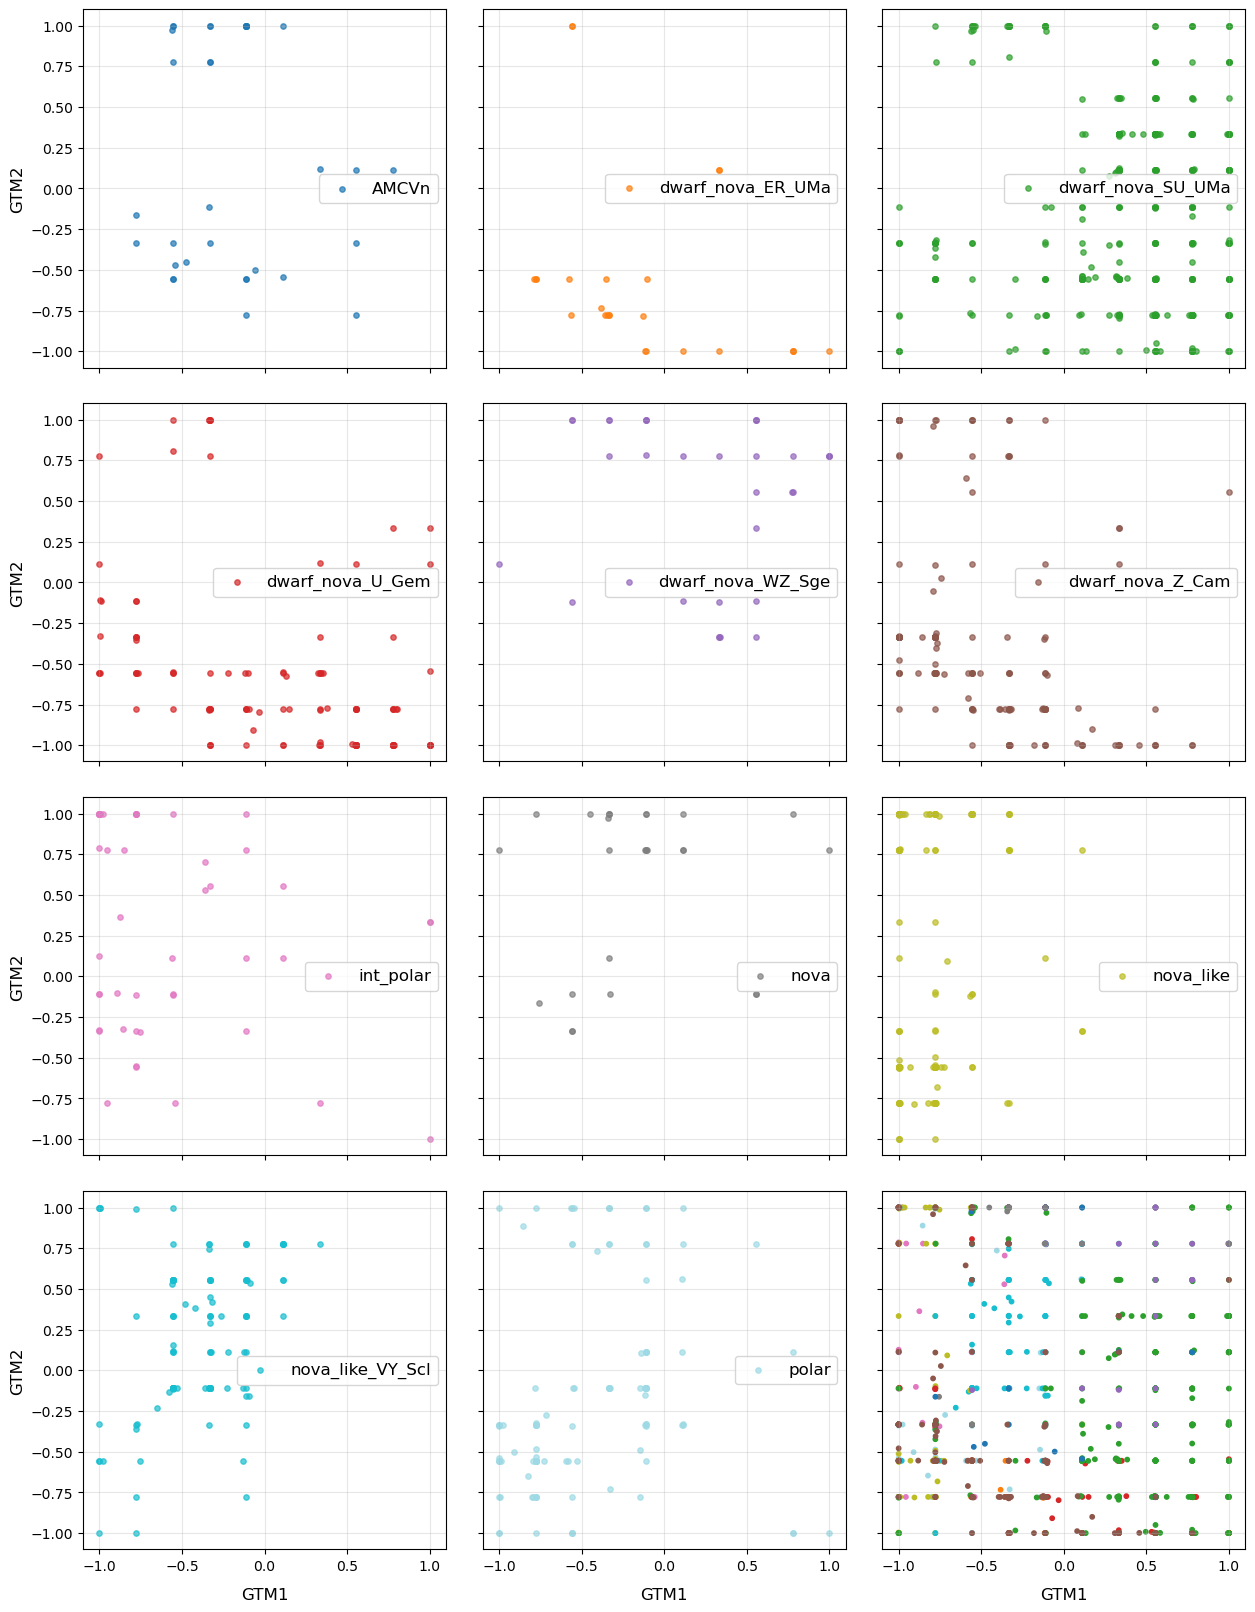

alt.Chart(...)

In [39]:
# Size of points in the projection
size = 30

mean_u = gtm_model.matMeans
modes_u = gtm_model.matModes

proj = 'mean' # 'mean' or 'modes'
if proj == 'mean':
    mpl_projection = mean_u
    x_alt = 'GTM1'
    y_alt = 'GTM2'
elif proj == 'mode':
    mpl_projection = modes_u
    x_alt = 'mode1'
    y_alt = 'mode2'

df_gtm_X = pd.DataFrame(mean_u, columns=['GTM1','GTM2'])

df_gtm_X = pd.concat([df_gtm_X, 
                      pd.Series(dataset_final.index, name='index'), 
                      dataset_final['oid_ztf'], 
                      dataset_final['type_aavso'],
                      pd.Series(y_names, name='label'),
                      pd.Series(modes_u[:,0], name='mode1'),
                      pd.Series(modes_u[:,1], name='mode2')
                      ], axis=1)

selection = alt.selection_point(fields=['label'], bind='legend')

projection_full = alt.Chart(df_gtm_X).mark_square().encode(
    x=x_alt,y=y_alt,
    color=alt.Color(shorthand='label', title='Class',
                    # Select a colour scheme for the classes where the colours are distinct, and more than 11 classes
                    scale=alt.Scale(domain=np.unique(y_names).tolist(),
                                    scheme='category20',
                                    # range=clr_range
                                    )),
    # shape='labels',
    size=alt.value(size),
    tooltip=["label", "index", "oid_ztf", "type_aavso"],
    opacity=alt.condition(selection, alt.value(0.8), alt.value(0.1))
    ).add_params(selection
    ).properties(title="GTM projection of X").interactive()


# Use matplotlib subplots to plot one class versus the rest for each of the classes, where the last subplot is all the classes.
fig, ax = plt.subplots(4,3, figsize=(15,20), sharex=True, sharey=True)
ax = ax.flatten()
# use the cmap tab20 for the first 11 classes
c = plt.cm.tab20(np.linspace(0,1,11))
# can you perform the above as a list of colours from tab20?

for i in range(11):
    # use the color keyword argument to set the colour of the points instead of c
    ax[i].scatter(mpl_projection[y==i,0], mpl_projection[y==i,1], label=enc.inverse_transform([i])[0], s=15, color=c[i], alpha=0.7)
    ax[i].scatter(mpl_projection[y!=i,0], mpl_projection[y!=i,1], c='grey', s=30, alpha=0.001)
    ax[i].grid(alpha=0.3)
    if i in [0,3,6,9]:
        ax[i].set_ylabel(f'GTM2', fontsize=12)
    if i in [9,10]:
        ax[i].set_xlabel(f'GTM1', fontsize=12)
        ax[i].xaxis.labelpad = 10
    ax[i].legend(fontsize=12)
# Use the class colours for the last subplot
ax[11].scatter(mpl_projection[:,0], mpl_projection[:,1], s=10, alpha=1, c=y, cmap='tab20')
ax[11].set_xlabel(f'GTM1', fontsize=12)
ax[11].xaxis.labelpad = 10
ax[11].grid(alpha=0.3)
# reduce the gaps between subplots
plt.subplots_adjust(hspace=0.1, wspace=0.1)
if gaia == True:
    plt.savefig(f'../results/figures/unsupervised/projection_gtm_cvlist{cvlistdate}_lcdata{lightcurvesdate}_20gor20r_gaia.pdf', bbox_inches='tight')
elif gaia == False:
    plt.savefig(f'../results/figures/unsupervised/projection_gtm_cvlist{cvlistdate}_lcdata{lightcurvesdate}_20gor20r_lconly.pdf', bbox_inches='tight')
# plt.tight_layout()
plt.show()

projection_full
# alt.hconcat(projection_full, projection_train, projection_test)

In [41]:
# Each example in data space is asociated with a location in 2D space. The mapping depends on using either
# matMeans, or matModes. For example if a dataspace example is associated with a particular node, the mean position
# or median position of the datapoints associated with that Gaussian are used to map it to a point in 2D space. During training,
# the Gaussian center is alocated a position in data space based on the mean or median of points associated with it based on 
# responsibility. It is this mean or median that is used in combination with the wieghted contributions of all Gaussians
# that is used to to map the data point to 2D space. Subsequently, we can create a histogram of locations of each example in 2D space. Therefore,
# matMeans and matModes contains the positions of example in 2D space. 
# Create a 2D histogram, H contains the histogram values in a 2D array, this can be used to generate our plot with altair.
# This is like the number of examples associated with each cluster.

# Generate a 2D histogram of the GTM modes
H, xedges, yedges = np.histogram2d(gtm_model.matModes[:,0],gtm_model.matModes[:,1],[k,k])

# Create a dataframe of the histogram values
dfmap = pd.DataFrame(gtm_model.matX, columns=["x1", "x2"])
dfmap['Count'] = H.flatten() 
x1vals = dfmap['x1'].unique()
x2vals = dfmap['x2'].unique()
for count, i in enumerate(x1vals):
    dfmap.loc[dfmap['x1']==i, 'xnode'] = count
for count, i in enumerate(x2vals):
    dfmap.loc[dfmap['x2']==i, 'ynode'] = count

# Create a chart of the 2D histogram
chart_all = alt.Chart(dfmap).mark_square().encode(
    x=alt.X('x1', bin=alt.Bin(minstep=0.1), title='GTM1'),
    y=alt.Y('x2', bin=alt.Bin(minstep=0.1), title=None),
    # set a specific colour of black and adjust the alpha
    color = alt.value('black'),
    # adjust the alpha
    opacity=alt.value(0.7),
    # color = alt.Color('size:Q',
    #                   scale=alt.Scale(scheme='viridis')),
    # color=alt.Color('label:Q',
    #                scale=alt.Scale(scheme='viridis')),
    size='Count',
    tooltip=['x1','x2','Count','xnode:Q','ynode:Q'],
    #opacity='density'
).properties(title='Total', width = 200, height = 200)

def plotdfmap(df, colour, title, axislabelx, axislabely):
    dfmap = alt.Chart(df).mark_square().encode(
        x=alt.X('x1', bin=alt.Bin(minstep=0.1), title=axislabelx),
        y=alt.Y('x2', bin=alt.Bin(minstep=0.1), title=axislabely),
        color = alt.value(colour),
        opacity=alt.value(1),
        # color=alt.Color('label:Q',
        #                scale=alt.Scale(scheme='viridis')),
        size='Count',
        tooltip=['x1','x2','Count','xnode:Q','ynode:Q'],
        #opacity='density'
        ).properties(width = 200, height = 200, title=title)
    
    return dfmap


dfmapcv = []
dfmapcvplot = []
# matplotlib colour scheme for tab20 in a list
clr_range = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd',
             '#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf',
             '#aec7e8','#ffbb78','#98df8a','#ff9896','#c5b0d5',
             '#c49c94','#f7b6d2','#c7c7c7','#dbdb8d','#9edae5']

i=0
for cv in np.unique(df_gtm_X['label']):
    df_gtm_X_cv = df_gtm_X[df_gtm_X['label']==cv].reset_index(drop=True)
    H2, xedges2, yedges2 = np.histogram2d(x=df_gtm_X_cv['GTM1'],y=df_gtm_X_cv['GTM2'], bins=[xedges,yedges])
    # print(xedges2, yedges2)
    dfmap_class = pd.DataFrame(gtm_model.matX, columns=["x1", "x2"])
    dfmap_class['Count'] = H2.flatten()
    for count, j in enumerate(x1vals):
        dfmap_class.loc[dfmap['x1']==j, 'xnode'] = count
    for count, j in enumerate(x2vals):
        dfmap_class.loc[dfmap['x2']==j, 'ynode'] = count

    dfmapcv.append(dfmap_class)
    if cv == 'AMCVn':
        dfmapcvplot.append(plotdfmap(dfmap_class, clr_range[i], title=cv, axislabelx=None, axislabely='GTM2'))
    elif cv == 'dwarf_nova_U_Gem':
        dfmapcvplot.append(plotdfmap(dfmap_class, clr_range[i], title=cv, axislabelx=None, axislabely='GTM2'))
    elif cv == 'int_polar':
        dfmapcvplot.append(plotdfmap(dfmap_class, clr_range[i], title=cv, axislabelx=None, axislabely='GTM2'))
    elif cv == 'nova_like_VY_Scl':
        dfmapcvplot.append(plotdfmap(dfmap_class, clr_range[i], title=cv, axislabelx='GTM1', axislabely='GTM2'))
    elif cv == 'polar':
        dfmapcvplot.append(plotdfmap(dfmap_class, clr_range[i], title=cv, axislabelx='GTM1', axislabely=None))
    else:
        dfmapcvplot.append(plotdfmap(dfmap_class, clr_range[i], title=cv, axislabelx=None, axislabely=None))
    i+=1

dfmapchart = alt.vconcat()

row1 = dfmapcvplot[0] | dfmapcvplot[1] | dfmapcvplot[2]
row2 = dfmapcvplot[3] | dfmapcvplot[4] | dfmapcvplot[5]
row3 = dfmapcvplot[6] | dfmapcvplot[7] | dfmapcvplot[8]
row4 = dfmapcvplot[9] | dfmapcvplot[10] | chart_all

dfmapchart = row1 & row2 & row3 & row4
# different colour for each class

# Set color scheme after concatenating charts
dfmapchart = dfmapchart.configure_legend(
    # set the tick count to 10
    tickCount=7,
    padding=10,
    
)

# set the grid parameters
dfmapchart = dfmapchart.configure_axis(
    grid=True,
    gridOpacity=1,
    gridWidth=0.9,
)

dfmapchart = dfmapchart.configure_axisX(
    titlePadding=10,
)

dfmapchart

alt.VConcatChart(...)

### Construct reference maps

In [27]:
# matY has shape n_dimensions (number of features) * n_nodes in latent space. 
# Manifold in n-dimensional space (projection of matX in data space); 
# A point matY[:,i] is a center of a Gaussian component i on the manifold in data space. Y=WΦT
# Location of each node in the high dimensional space.
# It is related to the actual probability space through Y=W*phi(transpose).
# We therefore need to normalise the matrix to show the strength of a node's association to a given class relative to the other nodes.

refvect = gtm_model.matY
refvect = MinMaxScaler().fit_transform(refvect.T).T
# refvect = scaler2.inverse_transform(refvect.T).T

# Here we are plotting matX, the coordinates of the nodes in the 2D space. We will colour code them based on 'label'. So this will be a
# grid of pixels in 2D space that is colour coded by some parameter.
def plot_ref_vect(gtm_matX,label,title,fig_size=(100,100)):
    dfmap = pd.DataFrame(gtm_matX, columns=["x1", "x2"])
    dfmap['Value'] = label
    for count, i in enumerate(x1vals):
        dfmap.loc[dfmap['x1']==i, 'xnode'] = count
    for count, i in enumerate(x2vals):
        dfmap.loc[dfmap['x2']==i, 'ynode'] = count
    
    map = alt.Chart(dfmap).mark_square().encode(
        x=alt.X('x1'),#, axis=None),
        y=alt.Y('x2'),#, axis=None),
        color=alt.Color('Value:Q',
                        #scale=alt.Scale(scheme='viridis')),
                        scale=alt.Scale(scheme='turbo')),
        size=alt.value(120),
        tooltip=['x1','x2', 'Value:Q', 'xnode:Q', 'ynode:Q'],
        #opacity='density'
    ).properties(title = alt.TitleParams(text=[title[0:17],title[17:34]], fontSize=12), width = fig_size[0], height = fig_size[1])
    
    return map

varnames = [
    'AndersonDarling_g','Autocor_length_g','Con_g','Eta_e_g','MaxSlope_g',
    'PairSlopeTrend_g','PeriodLS_g','Mean_g','SmallKurtosis_g','StructureFunction_index_31_g',
    'Q31_color','StetsonJ','dif_max_median_g','dif_min_median_g','pwr_maxovermean_g', 
    'pnts_geq_rollMedWin20+3mag_g','rrate_2to5_g', 'drate_2to5_g', 'clr_bright','clr_faint',
]

# varnames = [
#     'parallax','pm','parallax_error','bp_rp','bp_g','g_rp',
#     'l','b','ecl_lon','ecl_lat'
# ]

# varnames = X_cols[200:]


var = 0
chart = alt.vconcat()
new_line = '\n'
for rr in range(100):
    row = alt.hconcat().resolve_scale(y='shared')
    for cc in range(5):
        if var<len(varnames):
            # print the index of varnames[var] within X_cols
            variableindex = X_cols.index(varnames[var])
            row |= plot_ref_vect(
                gtm_matX=gtm_model.matX,
                label=refvect[variableindex,:], 
                title=varnames[var])
            var = var + 1
    chart &= row

# chart.configure_axis(labelFontSize=0, titleFontSize=0, titleFontWeight='normal')
chart.configure_concat(
    spacing=10
    ).configure_view(
        strokeWidth=1
        ).configure_axis(
            labelFontSize=0, 
            titleFontSize=0, 
            titleFontWeight='normal'
            ).configure_title(
                fontSize=14
                ).configure_legend(
                    titleFontSize=12, 
                    labelFontSize=12)



alt.VConcatChart(...)

### Inspect examples assigned to each node

In [28]:
mode2_values = df_gtm_X.mode2.value_counts().index.tolist()
mode1_values = df_gtm_X.mode1.value_counts().index.tolist()
mode1_values.sort()
mode2_values.sort()

node_x = 0
node_y = 9
node_df = df_gtm_X[(df_gtm_X['mode1']==mode1_values[node_x]) & (df_gtm_X['mode2']==mode2_values[node_y])]
node_examples = node_df['oid_ztf'].to_list()
print(len(node_examples), *node_examples)

40 ZTF18adjvzzl ZTF18acckvtm ZTF17aabtdus ZTF18abasxce ZTF18aabsmhl ZTF17aabzspo ZTF18abcllsj ZTF17aaaukni ZTF18abxehba ZTF18aagrgoe ZTF19aadhejk ZTF19aafnqmb ZTF17aaawwxl ZTF18abbdnxv ZTF18abpoeas ZTF17aaaogze ZTF18aabiixt ZTF18aapsxwd ZTF17aabukrt ZTF18abqqzvy ZTF18abdimry ZTF17aaaskep ZTF17aabuwqx ZTF19acarstz ZTF18aaaashe ZTF17aaarxab ZTF18abajuez ZTF18aabiptl ZTF19aaeqlwu ZTF18acawffe ZTF18aabtynl ZTF18adaudst ZTF17aabtjog ZTF20acrbeha ZTF18aaueblh ZTF18admqaga ZTF17aabpiiv ZTF20abnrdev ZTF17aaanqyh ZTF17aabwliz


In [29]:
# Display lasair difference magnitude and apparent magnitude light curves.
index = 942
objects = [dataset_final.iloc[index,:]['oid_ztf']]
# objects = node_examples

date = '08102023'

# Apply errorbars
error = False

if error == True:
        errColalerce1 = 'sigmapsf'
        errColalerce2 = 'sigmapsf_corr_revised'
        errCollasair1 = 'sigmapsf'
        errCollasair2 = 'dc_sigmag'
else:
    errColalerce1 = None
    errColalerce2 = None
    errCollasair1 = None
    errCollasair2 = None

# Get the GTM responsiblity for each object
resp = pd.Series(gtm_model.matR.max(axis=1), name='resp')
resp_df = pd.concat([df_gtm_X, resp], axis=1)

for object in objects:
    manual_label = dataset_final[dataset_final['oid_ztf']==object]['labels_1'].values[0]
    oid_aavso = dataset_final[dataset_final['oid_ztf']==object]['oid_aavso'].values[0]
    type_aavso = dataset_final[dataset_final['oid_ztf']==object]['type_aavso'].values[0]
    responsibility = resp_df[resp_df['oid_ztf']==object]['resp'].values[0]
    print(object, manual_label, oid_aavso, type_aavso, responsibility)
    try:
        lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_{date}')
    except:
        # Create a folder within path for LCs if one does not exist
        if not os.path.exists(f'../lightcurves_dataset/lasair_non_dataset/cache'):
            os.makedirs(f'../lightcurves_dataset/lasair_non_dataset/cache')
        print('Not in dataset')
        download_lasair_lc([object], folderpath=f'../lightcurves_dataset/lasair_non_dataset', cache=f'../lightcurves_dataset/lasair_non_dataset/cache')
        lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_non_dataset')

    lc_lasair_appmag = lasair_clean(lc_lasair, limit=25, magerrlim=1)

    # print('Lasair difference magnitude')
    # display_lightcurve(lc_lasair,x='jd',y='magpsf',errorCol=errCollasair1)
    print('Lasair apparent magnitude')
    display_lightcurve(lc_lasair_appmag,x='jd',y='dc_mag',errorCol=errCollasair2)

ZTF18abjrcju dwarf_nova_SU_UMa MASTER OT J210622.20+252120.4 UGSU 0.9999999851667745
Lasair apparent magnitude


### Process and obtain GTM projections for non-model objects

In [86]:
# DEFINE A SUBSET OF NON-MODELLED DATA TO PROJECT BASED ON AAVSO TYPE
non_model_type = 'CV'

dataset_nonmodel = pd.read_csv(f'../processed_data/dataset_{cvlistdate}allfeatures_inc_labels{lightcurvesdate}.csv', low_memory=False)
# Generate a dataset of examples that have not been modelled
dataset_nonmodel = dataset_nonmodel[dataset_nonmodel['labels_1'].isna()].reset_index(drop=True)

# Apply current AAVSO labels
from lasairalertsfilter import coords_process, xmatchcvs

aavso_cvs_raw_current_path = '../processed_data/AAVSOCVsraw_19112023'
if not os.path.exists(f'{aavso_cvs_raw_current_path}_processed.csv'):
    aavso_cvs_current = coords_process(filepath=f'{aavso_cvs_raw_current_path}.csv', savepath=f'{aavso_cvs_raw_current_path}_processed.csv')
else:
    aavso_cvs_current = pd.read_csv(f'{aavso_cvs_raw_current_path}_processed.csv', keep_default_na=False)

current_labels = xmatchcvs(dataset_nonmodel, aavso_cvs_current)[['aavso_name','aavso_type']]
# Get the indices of the 'oid_aavso' and 'type_aavso' columns
oid_aavso_idx = dataset_nonmodel.columns.get_loc('oid_aavso')
type_aavso_idx = dataset_nonmodel.columns.get_loc('type_aavso')
# Drop columns 'oid_aavso' and 'type_aavso' from dataset_nonmodel
dataset_nonmodel = dataset_nonmodel.drop(['oid_aavso','type_aavso'], axis=1)
# Insert updated colums at the original indices
dataset_nonmodel.insert(oid_aavso_idx, 'oid_aavso', current_labels['aavso_name'])
dataset_nonmodel.insert(type_aavso_idx, 'type_aavso', current_labels['aavso_type'])


# Drop Gaia features
if gaia == False:
    dataset_nonmodel = dataset_nonmodel.iloc[:,:-34]

# Filter dataset
dataset_nonmodel_pts_threshold = dataset_nonmodel[(dataset_nonmodel['n_obs_g']>=20) | (dataset_nonmodel['n_obs_r']>=20)].reset_index(drop=True)
dataset_nonmodel_final = dataset_nonmodel_pts_threshold

print(dataset_nonmodel_final['type_aavso'].value_counts())

# Refine rows to a subset
dataset_nonmodel_final = dataset_nonmodel_final[dataset_nonmodel_final['type_aavso'].isin([non_model_type])].reset_index(drop=True)

# Features and labels.
X_nonmodel = dataset_nonmodel_final.iloc[:,14:]
X_cols_nonmodel = X_nonmodel.columns.tolist()

# Obtain model projections for non-modelled data
X_nonmodel_gtm = pipeline_sklearn.transform(X_nonmodel)
X_nonmodel_proc = pipeline_sklearn.named_steps['preprocessor'].transform(X_nonmodel)
X_nonmodel_proc = pipeline_sklearn.named_steps['reorder_cols'].transform(X_nonmodel_proc)
X_nonmodel_proc = pipeline_sklearn.named_steps['scaler'].transform(X_nonmodel_proc)
X_nonmodel_proc = pipeline_sklearn.named_steps['imputer'].transform(X_nonmodel_proc)


type_aavso
UG                 2109
CV                  219
UG+E                 61
CV+E                 17
UGSU                 13
UGSU:                11
AM                    9
NL+E                  8
UGSS                  6
NL/VY                 3
UGSU+E                3
AM:                   2
NA+UG                 2
NL                    2
                      2
UGSS+E                1
UGWZ+E+ZZ/GWLIB       1
UGWZ+E                1
UGER                  1
UG+EA                 1
N+UG                  1
UGER+UGZ              1
AM+E:                 1
AM+E                  1
NC+M                  1
NC                    1
DQ+E                  1
UGZ/IW                1
Name: count, dtype: int64


### Observe non-model projections

In [92]:
# Plot projection of unmodelled set using altair
df_gtm_nonmodel = pd.DataFrame(X_nonmodel_proc, columns=X_cols)
df_gtm_nonmodel['GTM1'] = X_nonmodel_gtm[:,0]
df_gtm_nonmodel['GTM2'] = X_nonmodel_gtm[:,1]
df_gtm_nonmodel['label'] = dataset_nonmodel_final['type_aavso']
df_gtm_nonmodel['index'] = dataset_nonmodel_final.index
df_gtm_nonmodel['oid_ztf'] = dataset_nonmodel_final['oid_ztf']

projection_dataframe = df_gtm_nonmodel

projection_nonmodel = alt.Chart(projection_dataframe).mark_square(size=20).encode(
    x=alt.X('GTM1', scale=alt.Scale(zero=False, domain=[-1, 1])),
    y=alt.Y('GTM2', scale=alt.Scale(zero=False, domain=[-1, 1])),
    # color the data point black
    color=alt.value('black'),
    # make them a different shape
    size = alt.value(50),
    tooltip=['index', 'oid_ztf', 'label'],
).interactive()

projection_nonmodel.title = 'UMAP Projection of non_model Set'
projection_nonmodel.configure_axis(
    grid=True,
    labelFontSize=12,
    titleFontSize=12,
    # Set the limit of the x-axis to 0
    titleFontWeight='normal'
    ).configure_title(
        fontSize=14
        ).configure_legend(
            titleFontSize=12, 
            labelFontSize=12
            
)

projection_nonmodel


alt.Chart(...)

In [80]:
dfmapchart

alt.VConcatChart(...)

### Display light curves of non-model objects

In [93]:
# Display lasair difference magnitude and apparent magnitude light curves.
index2 = [124] #dataset_nonmodel_final.index.tolist()

objects2 = dataset_nonmodel_final.iloc[index2]['oid_ztf'].to_list()
date = '08102023'

# Apply errorbars
error = False

if error == True:
        errColalerce1 = 'sigmapsf'
        errColalerce2 = 'sigmapsf_corr_revised'
        errCollasair1 = 'sigmapsf'
        errCollasair2 = 'dc_sigmag'
else:
    errColalerce1 = None
    errColalerce2 = None
    errCollasair1 = None
    errCollasair2 = None

for object in objects2:
    try:
        lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_{date}')
    except:
        # Create a folder within path for LCs if one does not exist
        if not os.path.exists(f'../lightcurves_dataset/lasair_non_dataset/cache'):
            os.makedirs(f'../lightcurves_dataset/lasair_non_dataset/cache')
        print('Not in dataset')
        download_lasair_lc([object], folderpath=f'../lightcurves_dataset/lasair_non_dataset', cache=f'../lightcurves_dataset/lasair_non_dataset/cache')
        lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_non_dataset')

    lc_lasair_appmag = lasair_clean(lc_lasair, limit=25, magerrlim=1)

    manual_label = dataset_nonmodel_final.loc[dataset_nonmodel_final['oid_ztf']==object, 'labels_1'].values[0]
    oid_aavso = dataset_nonmodel_final.loc[dataset_nonmodel_final['oid_ztf']==object, 'oid_aavso'].values[0]
    type_aavso = dataset_nonmodel_final.loc[dataset_nonmodel_final['oid_ztf']==object, 'type_aavso'].values[0]
    print(f'oid_ztf: {object}\nmanual_label: {manual_label}\noid_aavso: {oid_aavso}\ntype_aavso: {type_aavso}')
    display_lightcurve(lc_lasair_appmag,x='jd',y='dc_mag',errorCol=errCollasair2)

oid_ztf: ZTF18aazijsj
manual_label: nan
oid_aavso: SDSS J161012.52+222110.8
type_aavso: CV
